<a href="https://colab.research.google.com/github/imi2201/Capstone-Project/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 With CNN

## Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from pathlib import Path
import random

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/Dataset/

customers_dataset.csv	    order_reviews_dataset.csv		   products_dataset.csv
geolocation_dataset.csv     orders_dataset.csv			   seller_order.csv
order_items_dataset.csv     product_category_name_translation.csv  sellers_dataset.csv
order_payments_dataset.csv  product_items.csv			   skin-disease-datasaet.zip


In [ ]:
!unzip drive/MyDrive/Dataset/skin-disease-datasaet.zip

Archive:  drive/MyDrive/Dataset/skin-disease-datasaet.zip
   creating: skin-disease-datasaet/
   creating: skin-disease-datasaet/test_set/
   creating: skin-disease-datasaet/test_set/BA- cellulitis/
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (1).webp  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (104).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (106).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (115).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (119).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (124).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (135).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (139).jpg  
  inflating: skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (144).jpg  
  inflating: skin-disease-da

In [ ]:
#Directory Data
train_dir = '/content/skin-disease-datasaet/train_set'
test_dir = '/content/skin-disease-datasaet/test_set'

# Initialize counters
total_train_images = 0
total_test_images = 0

# Count images in train set
print("From train_dir")
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    num_images = len(os.listdir(category_dir))
    print(f"Train - {category}: {num_images} images")
    total_train_images += num_images
print("")

# Count images in test set
print("From test_dir")
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    num_images = len(os.listdir(category_dir))
    print(f"Test - {category}: {num_images} images")
    total_test_images += num_images
print("")

# Calculate total number of images
print(f"Total train images: {total_train_images}")
print(f"Total test images: {total_test_images}")

From train_dir
Train - VI-chickenpox: 136 images
Train - BA- cellulitis: 136 images
Train - VI-shingles: 130 images
Train - BA-impetigo: 80 images
Train - PA-cutaneous-larva-migrans: 100 images
Train - FU-ringworm: 90 images
Train - FU-nail-fungus: 129 images
Train - FU-athlete-foot: 124 images
Train - scar: 133 images

From test_dir
Test - VI-chickenpox: 34 images
Test - BA- cellulitis: 34 images
Test - VI-shingles: 33 images
Test - BA-impetigo: 20 images
Test - PA-cutaneous-larva-migrans: 25 images
Test - FU-ringworm: 23 images
Test - FU-nail-fungus: 33 images
Test - FU-athlete-foot: 32 images
Test - scar: 27 images

Total train images: 1058
Total test images: 261


## Data Visualization

In [ ]:
# Train Data Classes
classes = os.listdir(train_dir)
classes = sorted(classes)
print(f"Total classes = {len(classes)}")
print(f"Classes: {classes}")

Total classes = 9
Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles', 'scar']


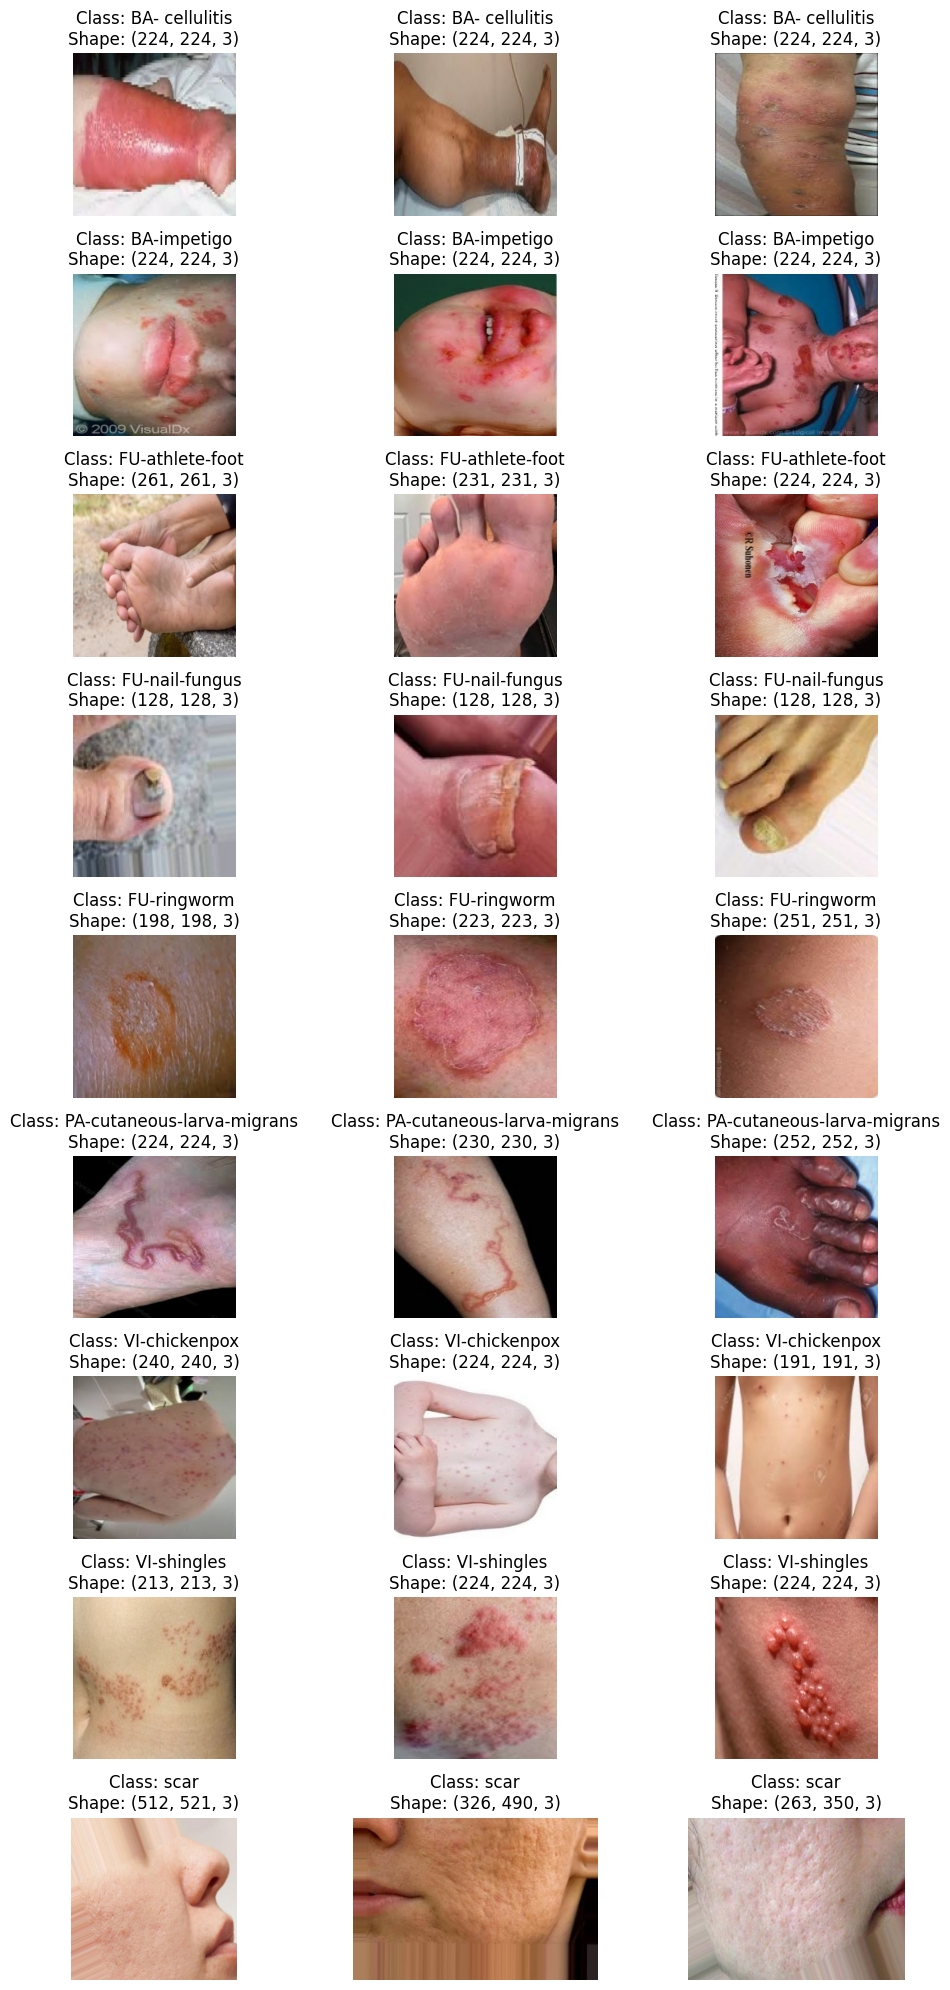

In [ ]:
NUM_OF_IMAGE = 3  # Number of images to generate

# Initialize the figure
fig, ax = plt.subplots(nrows=len(classes), ncols=NUM_OF_IMAGE, figsize=(10, 20))

# Loop through each class
for p, c in enumerate(classes):
    img_path_class = list(Path(os.path.join(train_dir, c)).glob("*.jpg"))
    img_path_class += list(Path(os.path.join(train_dir, c)).glob("*.jpeg"))

    # Check if the number of available images is less than NUM_OF_IMAGE
    if len(img_path_class) < NUM_OF_IMAGE:
        print(f"Warning: Not enough images in class '{c}' to select {NUM_OF_IMAGE} images.")
        img_selected = img_path_class  # Select all available images
    else:
        img_selected = random.choices(img_path_class, k=NUM_OF_IMAGE)

    # Loop through selected images
    for i, j in enumerate(img_selected):
        img_bgr = cv2.imread(str(j))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p, i].imshow(img_rgb)
        ax[p, i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p, i].axis('off')

fig.tight_layout()
plt.show()

## Building the Model

In [ ]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

## Data Preprocessing

### Train_Data

In [ ]:
# Define your data directory
data_dir = '/content/skin-disease-datasaet'

# List all class subdirectories
class_subdirs = os.listdir(data_dir)

# Initialize empty lists for images and labels
train_images = []
train_labels = []

# Load images and labels
for class_subdir in class_subdirs:
    class_path = os.path.join(data_dir, class_subdir)
    class_images = os.listdir(class_path)
    for image_filename in class_images:
        image_path = os.path.join(class_path, image_filename)
        image = cv2.imread(image_path)  # Read the image using OpenCV
        train_images.append(image)
        train_labels.append(class_subdir)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values (if not already done)
train_images = train_images.astype('float32') / 255

# Print the shapes of the loaded data (for verification)
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (18,)
Train labels shape: (18,)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,              # target dir
    target_size=(150, 150), # resizes all images to 150x150
    #batch_size=20, # by default 32
    class_mode='categorical'     # Binary labels needed with binary_crossentropy loss
)



Found 1057 images belonging to 9 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break # Necessary because the generator yields batches indefinitely

Data batch shape: (32, 150, 150, 3)
Labels batch shape: (32, 9)


In [ ]:
batch_images, batch_labels = next(train_generator)


In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7, 'scar': 8}


### Test_data

In [ ]:
# rescale all images by 1/255
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,              # target dir
    target_size=(150, 150), # resizes all images to 150x150
    batch_size=20,
    class_mode='categorical')    # Binary labels needed with binary_crossentropy loss


Found 260 images belonging to 9 classes.


In [ ]:
test_images, test_labels = next(test_generator)

## Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'], run_eagerly=True
)


In [ ]:
history = model.fit(
    train_generator,
    epochs=25,
    batch_size=15,
    validation_data=test_generator
    )

Epoch 1/25
34/34 [==============================] - 116s 3s/step - loss: 2.2188 - accuracy: 0.1116 - val_loss: 2.1872 - val_accuracy: 0.1269
Epoch 2/25
34/34 [==============================] - 113s 3s/step - loss: 2.1709 - accuracy: 0.1372 - val_loss: 2.2259 - val_accuracy: 0.1269
Epoch 3/25
34/34 [==============================] - 125s 4s/step - loss: 2.1342 - accuracy: 0.1552 - val_loss: 2.0640 - val_accuracy: 0.1923
Epoch 4/25
34/34 [==============================] - 113s 3s/step - loss: 2.0858 - accuracy: 0.2034 - val_loss: 1.9913 - val_accuracy: 0.2192
Epoch 5/25
34/34 [==============================] - 114s 3s/step - loss: 2.0335 - accuracy: 0.1987 - val_loss: 1.9781 - val_accuracy: 0.2192
Epoch 6/25
34/34 [==============================] - 117s 3s/step - loss: 1.9125 - accuracy: 0.2375 - val_loss: 2.4774 - val_accuracy: 0.2038
Epoch 7/25
34/34 [==============================] - 114s 3s/step - loss: 1.9400 - accuracy: 0.2687 - val_loss: 1.8653 - val_accuracy: 0.3000
Epoch 8/25
34

## Model Testing

## Converting to H5 and Json